In [1]:
## Spotify Authentication
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def spotify_auth():
    client_credentials_manager = SpotifyClientCredentials(client_id='06f805df51314c0ba60b789ddfdbbc3b', 
                                                          client_secret='a72df60abfa94a378f025b4d40b101b8')
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp

In [2]:
sp = spotify_auth()

In [3]:
## Automate getting spotify track ID
def get_spotify_track_id(sp, song_title, artist_name):
    query = f"track:{song_title} artist:{artist_name}"
    results = sp.search(q=query, type='track', limit=1)
    
    if results['tracks']['items']:
        track = results['tracks']['items'][0]
        return track['id']  # Return the track ID
    else:
        print(f"No track found for '{song_title}' by {artist_name}")
        return None

In [4]:
## Getting music data
def extract_track_id(spotify_url):
    # Check if the URL contains a valid Spotify track link and extract the track ID
    if "track" in spotify_url:
        return spotify_url.split("/")[-1].split("?")[0]
    return None

def get_audio_features(sp, track_id):
    # Fetch audio features for the track using the extracted track ID
    audio_features = sp.audio_features(track_id)[0]
    
    return {
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'],
        'tempo': audio_features['tempo'],
        'valence': audio_features['valence'],
        'loudness': audio_features['loudness']
    }

def get_track_data(sp, track_url):
    # Step 1: Extract the track ID from the URL
    track_id = extract_track_id(track_url)
    
    if track_id:
        # Step 2: Fetch track info and audio features using the track ID
        track_info = sp.track(track_id)
        audio_features = get_audio_features(sp, track_id)
        
        # Step 3: Return combined track info and audio features
        return {
            'track_name': track_info['name'],
            'artist_name': track_info['artists'][0]['name'],
            'artist_id': track_info['artists'][0]['id'],
            **audio_features  # Merge audio features into the same dictionary
        }
    else:
        print("Invalid Spotify track URL")
        return None

In [5]:
## Combine all that data from above
def combine_features(sentiment, audio_features, song_title):
    # Combine sentiment analysis and audio features into one dictionary
    combined_data = {
        'title': song_title,
        'polarity': sentiment['polarity'],
        'subjectivity': sentiment['subjectivity'],
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'],
        'valence': audio_features['valence'],
        'tempo': audio_features['tempo'],
        'loudness': audio_features['loudness']
    }
    return combined_data

In [6]:
## Connecting Genius for lyrics
import requests

GENIUS_API_TOKEN = "hCh2EE7VW9PMbvQ0AWKiVWtM2-Kcc2CLQpoGMf02V4gchhcopUn-_3WEQMCTzdlQ"

# Search for song using Genius API
def search_song_on_genius(song_title, artist_name):
    base_url = "https://api.genius.com"
    headers = {"Authorization": f"Bearer {GENIUS_API_TOKEN}"}
    search_url = f"{base_url}/search"
    
    # Search query with song title and artist
    data = {'q': f"{song_title} {artist_name}"}
    response = requests.get(search_url, headers=headers, params=data)
    
    if response.status_code == 200:
        json_data = response.json()
        hits = json_data['response']['hits']
        if hits:
            # Take first match
            return hits[0]['result']['id']
        else:
            print("No song found.")
            return None
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None
    
# Little test
song_id = search_song_on_genius("Nude", "Radiohead")
print(song_id) # Should print song id if song is found

65923


In [7]:
## Fetching song lyrics from Genius website
from bs4 import BeautifulSoup

# Function to get the song URL from song ID
def get_song_url_from_genius(song_id):
    base_url = "https://genius.com/songs/"
    song_url = f"{base_url}{song_id}"
    return song_url

# Function to scrape the lyric from song page (Genius copyright so gotta do it like this)
def scrape_lyrics_from_genius(song_url):
    response = requests.get(song_url)
    
    if response.status_code == 200:
        html = BeautifulSoup(response.text, 'html.parser')
        
        # Sometimes the lyrics might be broken into multiple <div> elements
        lyrics = ""
        
        # Find all divs with class that starts with "Lyrics__Container"
        for div in html.find_all("div", class_=lambda value: value and value.startswith("Lyrics__Container")):
            lyrics += div.get_text(separator="\n").strip() + "\n"
        
        # If we successfully scraped some lyrics
        if lyrics:
            return lyrics.strip()
        else:
            print("Lyrics not found on the page.")
            return None
    else:
        print(f"Error {response.status_code}: Couldn't fetch the page.")
        return None
    
# Little test
song_id = search_song_on_genius("Nude", "Radiohead")
song_url = get_song_url_from_genius(song_id)
lyrics = scrape_lyrics_from_genius(song_url)

if lyrics:
    print(lyrics)

[Verse 1]
Don't get any big ideas
They're not gonna happen
You paint yourself white
And fill up with noise
But there'll be something missing
[Chorus]
Now that you've found it, it's gone
Now that you feel it, you don't
You've gone off the rails
[Verse 2]
So don't get any big ideas
They're not gonna happen
You'll go to hell
For what your dirty mind is thinking


In [8]:
# ## Sentiment Analysis
# from textblob import TextBlob

# def analyze_lyrics_sentiment(lyrics):
#     blob = TextBlob(lyrics)
#     sentiment = blob.sentiment
#     return {
#         'polarity': sentiment.polarity,  # How positive or negative the sentiment is
#         'subjectivity': sentiment.subjectivity  # How subjective or objective the lyrics are
#     }

# # Little test
# if lyrics:
#     sentiment = analyze_lyrics_sentiment(lyrics)
#     print(f"Polarity: {sentiment['polarity']}, Subjectivity: {sentiment['subjectivity']}")

In [9]:
## Sentiment Analysis using VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis using VADER
def analyze_lyrics_sentiment_vader(lyrics):
    sentiment_scores = vader.polarity_scores(lyrics)
    return {
        'polarity': sentiment_scores['compound'],  # The overall sentiment score
        'subjectivity': sentiment_scores['neu']  # Neutral component (approximating subjectivity)
    }

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abytr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
## Visualize sentiment analysis and audio features!
import matplotlib.pyplot as plt

def plot_multiple_songs(songs_data):
    # Prepare lists to store data for plotting
    titles = [song['title'] for song in songs_data]
    polarities = [song['polarity'] for song in songs_data]
    subjectivities = [song['subjectivity'] for song in songs_data]
    
    danceabilities = [song['danceability'] for song in songs_data]
    energies = [song['energy'] for song in songs_data]
    valences = [song['valence'] for song in songs_data]
    
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for sentiment analysis (Polarity vs Subjectivity)
    plt.subplot(1, 2, 1)
    plt.scatter(polarities, subjectivities, color='blue')
    for i, title in enumerate(titles):
        plt.annotate(title, (polarities[i], subjectivities[i]))
    plt.title('Polarity vs Subjectivity (Lyrics Sentiment)')
    plt.xlabel('Polarity')
    plt.ylabel('Subjectivity')
    
    # Bar plot for audio features (Danceability, Energy, Valence) for all songs
    plt.subplot(1, 2, 2)
    bar_width = 0.2
    index = range(len(titles))
    
    plt.bar(index, danceabilities, bar_width, label='Danceability', color='green')
    plt.bar([i + bar_width for i in index], energies, bar_width, label='Energy', color='blue')
    plt.bar([i + 2 * bar_width for i in index], valences, bar_width, label='Valence', color='red')
    
    plt.xlabel('Songs')
    plt.ylabel('Audio Feature Value (0-1)')
    plt.title('Audio Features Comparison')
    plt.xticks([i + bar_width for i in index], titles, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# Test
#sentiment_data = [
#    {'title': 'Nude', 'polarity': sentiment['polarity'], 'subjectivity': sentiment['subjectivity']}
#]

#plot_sentiment(sentiment_data)

In [11]:
# For comparing several songs
def collect_multiple_songs_data(sp):
    songs_data = []
    num_songs = int(input("How many songs do you want to analyze? "))
    
    for _ in range(num_songs):
        # Get user input for each song
        song_title = input("Enter the song title: ")
        artist_name = input("Enter the artist name: ")
        
        # Genius lyrics search
        song_id = search_song_on_genius(song_title, artist_name)
        if song_id:
            song_url = get_song_url_from_genius(song_id)
            lyrics = scrape_lyrics_from_genius(song_url)
            if lyrics:
                # Perform sentiment analysis
                sentiment = analyze_lyrics_sentiment_vader(lyrics)
                
                # Get Spotify audio features
                track_id = get_spotify_track_id(sp, song_title, artist_name)
                if track_id:
                    audio_features = get_audio_features(sp, track_id)
                    
                    # Combine sentiment and audio features
                    combined_data = combine_features(sentiment, audio_features, song_title)
                    songs_data.append(combined_data)
                else:
                    print(f"Could not retrieve audio features for '{song_title}'.")
            else:
                print(f"No lyrics found for '{song_title}'.")
        else:
            print(f"No song found for '{song_title}'.")
    
    return songs_data

How many songs do you want to analyze? 3
Enter the song title: Nude
Enter the artist name: Radiohead
Enter the song title: One More Time
Enter the artist name: Daft Punk
Enter the song title: Kiss of Life
Enter the artist name: Sade


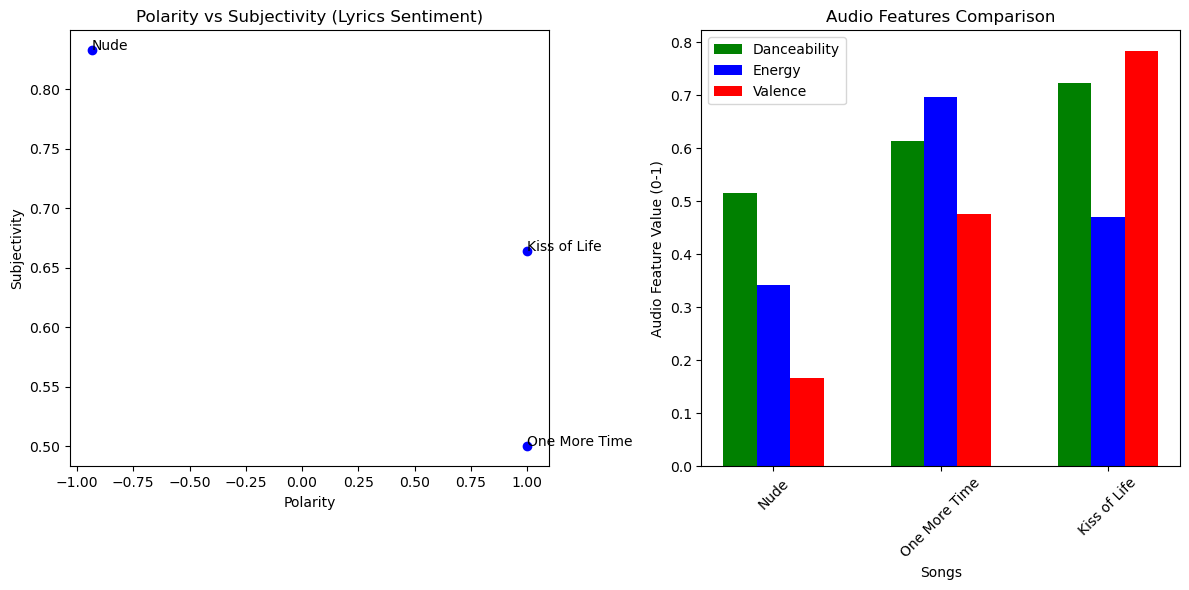

In [12]:
def main():
    # Collect data for multiple songs
    songs_data = collect_multiple_songs_data(sp)

    if songs_data:
        # Plot data for multiple songs
        plot_multiple_songs(songs_data)
    else:
        print("No data to plot.")

main()